In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env, acquire

In [4]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [21]:
query = """select calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, taxvaluedollarcnt
           from properties_2017
           join predictions_2017 using(parcelid)
           where transactiondate between '2017-05-01' and '2017-06-30'
           and propertylandusetypeid in (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        """

def get_zillow_data():
    filename = 'zillow.csv'
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv(filename)
        return df

## Data Acquisition

In [2]:
df = acquire.acquire_cache_data()
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


## Data Preparation
### Summarize the data
- df.info()
- df.describe()
- df.dtypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20318 non-null  float64
 1   bathroomcnt                   20364 non-null  float64
 2   bedroomcnt                    20364 non-null  float64
 3   taxvaluedollarcnt             20364 non-null  float64
dtypes: float64(4)
memory usage: 636.5 KB


In [6]:
df. describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20318.000000,20364.000000,20364.000000,2.036400e+04
mean,1776.493208,2.284694,3.019839,5.054039e+05
std,936.606498,0.958072,1.030974,6.584038e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1176.000000,2.000000,2.000000,2.104808e+05
50%,1536.000000,2.000000,3.000000,3.665045e+05
75%,2102.000000,3.000000,4.000000,5.890250e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


In [7]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
dtype: object

### Address missing values
**Takeways**
- 70 observations has bathroom count 0
- 136 observations has bedroom count 0
- 46 observations has square feet as null
- How to deal with them? Drop all the observations with 0 or NaN values

In [14]:
df[df.bathroomcnt == 0].shape

(70, 4)

In [11]:
df[df.bedroomcnt == 0].shape

(136, 4)

In [33]:
df.calculatedfinishedsquarefeet.isnull().sum()

46

In [38]:
# Drop all the obervations with null or 0

mask_bathr = (df.bathroomcnt == 0)
mask_bedr = (df.bedroomcnt == 0)
mask_sf = df.calculatedfinishedsquarefeet.isnull()

mask = mask_bathr | mask_bedr | mask_sf
mask.sum()

df = df[-mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20223 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20223 non-null  float64
 1   bathroomcnt                   20223 non-null  float64
 2   bedroomcnt                    20223 non-null  float64
 3   taxvaluedollarcnt             20223 non-null  float64
dtypes: float64(4)
memory usage: 790.0 KB


In [43]:
# Double check to make sure my code remove all the missing values.

bathr_missing = df[df.bathroomcnt == 0].shape[0]
bedr_missing = df[df.bedroomcnt == 0].shape[0]
sf_missing = df.calculatedfinishedsquarefeet.isnull().sum()

bathr_missing, bedr_missing, sf_missing

(0, 0, 0)

### Address dupliates
**Takeways**
- 61 obervations were duplicates
- How to deal with them? Drop all the duplicates

In [44]:
df.duplicated().sum()

58

In [45]:
df = df.drop_duplicates(keep='first', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


### Pairplot the variables

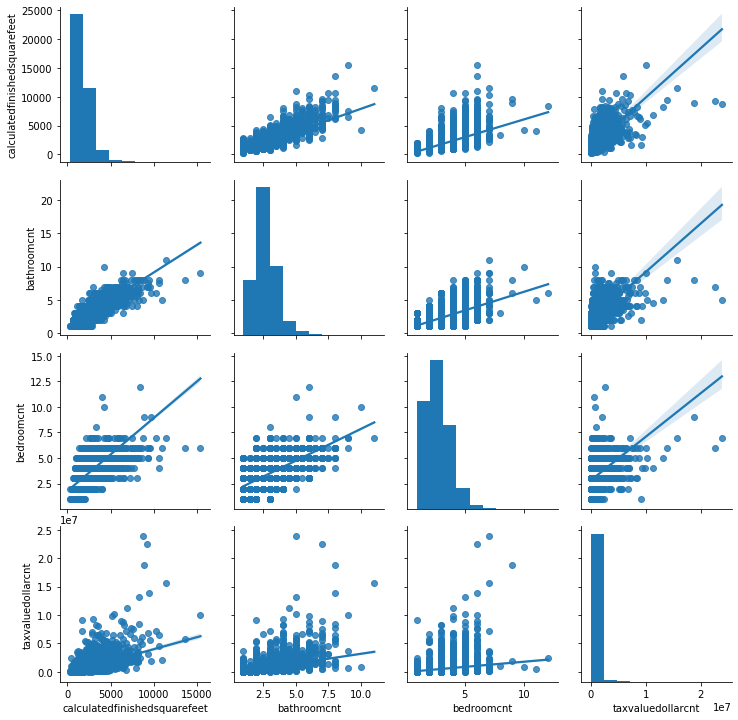

In [46]:
sns.pairplot(df, kind='reg')

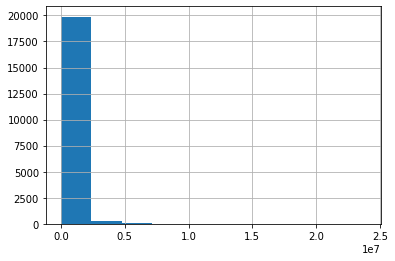

In [47]:
df.taxvaluedollarcnt.hist()